Use ccl to compute theory curve for galaxies

In [1]:
import numpy as np
import pylab as pl

In [2]:
# grab a theory curve:
omega_M = 0.3147
omega_L = 0.6853
omega_B = 0.04904
h = 0.6731
w = -1.0
ns = 0.9655
sigma_8 = 0.83

# grab CCL theory curve:


In [3]:
import pyccl as ccl
ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = True
cosmo_ccl = ccl.Cosmology(Omega_c = omega_M-omega_B, Omega_b = omega_B, h = h, 
                          sigma8 = sigma_8, n_s = ns)

In [5]:
bias_z = np.loadtxt("../bias_dc2.txt")

In [4]:
# load n(z), b(z)
import yaml

root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/'
packed_stats_fzb_source={}
for year in [1,3,5]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-source-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_fzb_source[year]=yaml.load(stream,Loader=yaml.Loader)
        
# take some tomo graphic binning:
year = 5
nz_tomo = {}
nz_tomo_tot = 0
for kk in range(5):
    nz = packed_stats_fzb_source[year]["tomo-%d"%(kk+1)]["nztot"]
    y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
    nz_tomo[kk] = np.c_[nz[:,0], y]
    nz_tomo_tot += nz[:,1]
nz_tomo_tot = nz_tomo_tot/sum(nz_tomo_tot)/(nz[1,0]-nz[0,0])

In [ ]:
# interp
bias_z_int = np.interp(nz_tomo[kk][:,0], bias_z[:,0], bias_z[:,1])

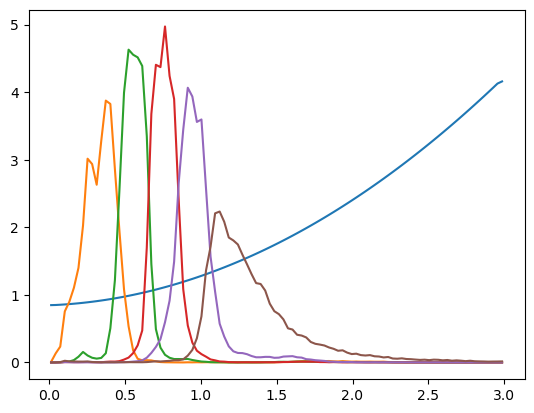

In [9]:
pl.plot(nz_tomo[kk][:,0],bias_z_int)
for ii in range(5):
    pl.plot(nz_tomo[ii][:,0],nz_tomo[ii][:,1])

In [ ]:
root="/pscratch/sd/q/qhang/desi-lya/"
ell=np.arange(1,1001)
clth = np.zeros((1001,5))
for ii in range(5):
    
    #fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-fzb.dat")
    #finzbin = fin[:,0]
    #finzz = (finzbin[1:]+ finzbin[:-1])/2.
    #finnz = fin[:-1,1]
    
    # try ccl:
    nz = nz_tomo[ii][:,1]
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(nz_tomo[ii][:,0], nz), 
                                          bias=(nz_tomo[ii][:,0],bias_z_int))

    tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
    clth[:,ii] = np.append(0, tmp)

fname = root+"clgg-theory.txt"
np.savetxt(fname, clth)

In [10]:
# grab theory form n(z):
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
galnz = np.loadtxt(saveroot + "gal-nzcount-truezbin.txt")

zz = (galnz[1:,0] +  galnz[:-1,0])/2.

bias_z_int = np.interp(zz, bias_z[:,0], bias_z[:,1])

In [11]:
root="/pscratch/sd/q/qhang/desi-lya/"
ell=np.arange(1,1001)
clth = np.zeros((1001,5))
for ii in range(5):

    nz = galnz[:-1,ii+1]
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=True, dndz=(zz, nz), 
                                          bias=(zz,bias_z_int))

    tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
    clth[:,ii] = np.append(0, tmp)

fname = root+"clgg-theory-truezbin.txt"
np.savetxt(fname, clth)

# Correlation in bins:

In [7]:
# load redshift distributions for phot and lya sample (assume tophat):
# mock 0
root="/pscratch/sd/q/qhang/desi-lya/results/run-0/"
fname = root + "catalogue/nz-unknown-zmin-1.8-zmax-3.0.txt"
nz_phot = np.loadtxt(fname)
print(nz_phot.shape)
# both 20 bins and 40 bins - use 40 bins to find the bias evolution - > apply to 20 bin case

(80, 2)


In [8]:
print(nz_phot[:,0])

[0.01875    0.05625    0.09375    0.13124999 0.16875    0.20625
 0.24374999 0.28125    0.31875002 0.35624999 0.39375001 0.43124998
 0.46875    0.50625002 0.54374999 0.58125001 0.61874998 0.65625
 0.69375002 0.73124999 0.76875001 0.80624998 0.84375    0.88125002
 0.91874999 0.95625001 0.99375004 1.03125    1.0687499  1.10625005
 1.14374995 1.1812501  1.21875    1.2562499  1.29375005 1.33124995
 1.3687501  1.40625    1.4437499  1.48125005 1.51874995 1.5562501
 1.59375    1.6312499  1.66875005 1.70624995 1.7437501  1.78125
 1.8187499  1.85625005 1.89374995 1.9312501  1.96875    2.0062499
 2.04375005 2.08124995 2.1187501  2.15625    2.1937499  2.23125005
 2.26874995 2.3062501  2.34375    2.3812499  2.41875005 2.45624995
 2.4937501  2.53125    2.5687499  2.60625005 2.64374995 2.6812501
 2.71875    2.7562499  2.79375005 2.83124995 2.8687501  2.90625
 2.9437499  2.98125005]


In [83]:
zsamp = np.linspace(0,3,200)
dz = zsamp[1]-zsamp[0]
binedges = np.linspace(2,3,41)
nz_phot_interp= np.interp(zsamp, nz_phot[:,0], nz_phot[:,1])
nz_phot_interp = nz_phot_interp/sum(nz_phot_interp)/dz
ell=np.arange(1,3001)
theta = np.linspace(10/60, 30/60, 10)#degrees
zbins = (binedges[1:] +  binedges[:-1])/2.

In [36]:
# auto-correlation:
w_ss = np.zeros(len(binedges)-1)
for ii in range(len(binedges)-1):
    zsamp_lyaf = np.linspace(binedges[ii],binedges[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, np.ones(len(zsamp_lyaf))))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_ss[ii] = np.mean(w1)

In [54]:
data_wss = np.loadtxt("mock0-wss-40bins-baseline-raw.txt")
data_wss20 = np.loadtxt("mock0-wss-20bins-baseline-raw.txt")

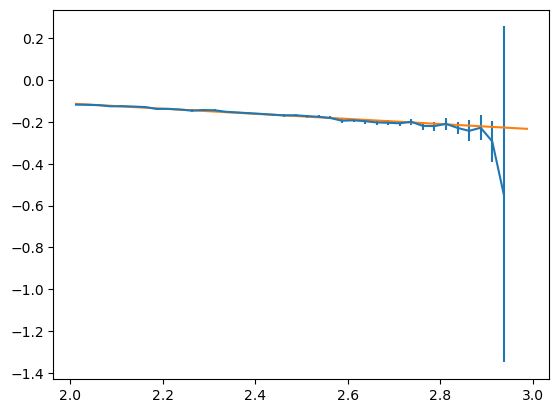

In [50]:
blya_meas = - np.sqrt(data_wss[:,1]/w_ss)
blya_meas_err = abs((data_wss[:,2]/data_wss[:,1])*blya_meas)
pl.errorbar(zbins, blya_meas, yerr=blya_meas_err)
# fit a straight line through the curves:
poly=np.polyfit(zbins[:-2], blya_meas[:-2], 1, w=1/blya_meas_err[:-2])
pl.plot(zbins, zbins*poly[0] + poly[1])

In [110]:
print(poly)

[-0.1224972   0.13334162]


In [101]:
# auto-correlation:
w_ss_fitted = np.zeros(len(binedges)-1)
for ii in range(len(binedges)-1):
    zsamp_lyaf = np.linspace(binedges[ii],binedges[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, zsamp_lyaf*poly[0] + poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_ss_fitted[ii] = np.mean(w1)

In [59]:
# now compute the 20-bin auto-correlation and see if we get consistent result:
binedges20 = np.linspace(2,3,21)
zbins20 = (binedges20[1:]+binedges20[:-1])/2.
# auto-correlation:
w_ss20 = np.zeros(len(binedges20)-1)
for ii in range(len(binedges20)-1):
    zsamp_lyaf = np.linspace(binedges20[ii],binedges20[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, zsamp_lyaf*poly[0] + poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_ss20[ii] = np.mean(w1)

Text(0.5, 1.0, '$\\theta=[10,30]$ arcmin, 20 bins')

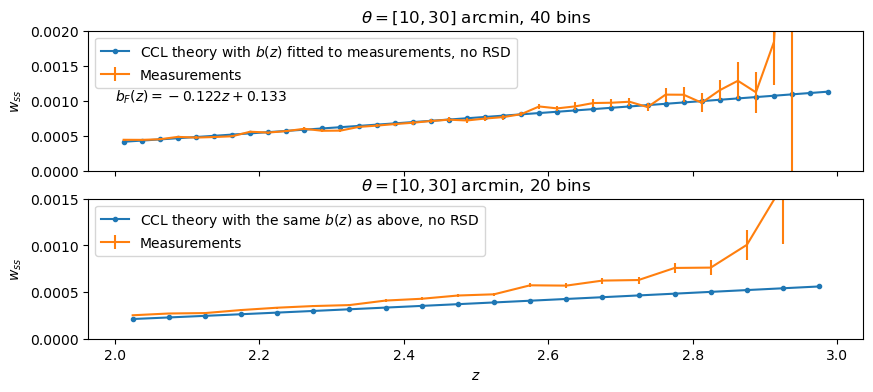

In [134]:
fig,axarr=pl.subplots(2,figsize=[10,4],sharex=True)
pl.sca(axarr[0])
pl.plot(zbins, w_ss_fitted, '.-',label="CCL theory with $b(z)$ fitted to measurements, no RSD")
pl.errorbar(data_wss[:,0], data_wss[:,1],yerr=data_wss[:,2], label="Measurements")
pl.ylim([0,0.002])
pl.ylabel("$w_{ss}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 40 bins")
pl.text(2,0.001,f"$b_F(z) = {round(poly[0],3)}z + {round(poly[1],3)}$")

pl.sca(axarr[1])
pl.plot(zbins20, w_ss20,'.-',label="CCL theory with the same $b(z)$ as above, no RSD")
pl.errorbar(data_wss20[:,0], data_wss20[:,1],yerr=data_wss20[:,2], label="Measurements")
pl.xlabel("$z$")
pl.ylabel("$w_{ss}$")
pl.ylim([0,0.0015])
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 20 bins")

In [71]:
data_wpp = np.loadtxt("mock0-wpp-40bins-baseline.txt")
data_wpp20 = np.loadtxt("mock0-wpp-20bins-baseline.txt")

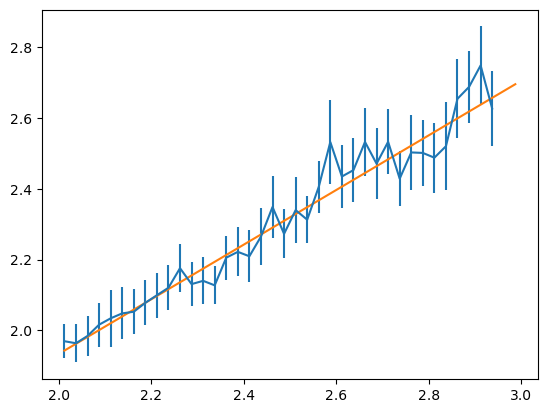

In [69]:
bp_meas = np.sqrt(data_wpp[:,1]/w_ss)
bp_meas_err = abs((data_wpp[:,2]/data_wpp[:,1])*bp_meas)
pl.errorbar(zbins[:-2], bp_meas[:-2], yerr=bp_meas_err[:-2])
# fit a straight line through the curves:
poly_pp=np.polyfit(zbins[:-2], bp_meas[:-2], 1, w=1/bp_meas_err[:-2])
pl.plot(zbins, zbins*poly_pp[0] + poly_pp[1])

In [117]:
poly_pp

array([0.77305949, 0.38654076])

In [116]:
# use this to predict the correlation in 20 bins:
# now compute the 20-bin auto-correlation and see if we get consistent result:
w_pp_fitted = np.zeros(len(binedges)-1)
for ii in range(len(binedges)-1):
    zsamp_lyaf = np.linspace(binedges[ii],binedges[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, zsamp_lyaf*poly_pp[0] + poly_pp[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_pp_fitted[ii] = np.mean(w1)

In [70]:
# use this to predict the correlation in 20 bins:
# now compute the 20-bin auto-correlation and see if we get consistent result:
w_pp20 = np.zeros(len(binedges20)-1)
for ii in range(len(binedges20)-1):
    zsamp_lyaf = np.linspace(binedges20[ii],binedges20[ii+1],50)
    dz = zsamp_lyaf[1]-zsamp_lyaf[0]
    nz_lyaf = np.ones(len(zsamp_lyaf))
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp_lyaf, nz_lyaf), 
                                          bias=(zsamp_lyaf, zsamp_lyaf*poly_pp[0] + poly_pp[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu2, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_pp20[ii] = np.mean(w1)

Text(0.5, 0, '$z$')

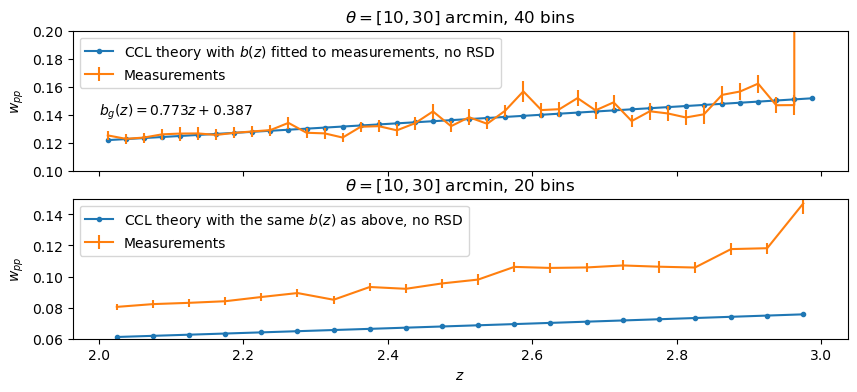

In [135]:
fig,axarr=pl.subplots(2,figsize=[10,4],sharex=True)
pl.sca(axarr[0])
pl.plot(zbins, w_pp_fitted,'.-',label="CCL theory with $b(z)$ fitted to measurements, no RSD")
pl.errorbar(data_wpp[:,0], data_wpp[:,1],yerr=data_wpp[:,2],label="Measurements")
pl.ylim([0.1,0.20])
pl.ylabel("$w_{pp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 40 bins")
pl.text(2,0.14,f"$b_g(z) = {round(poly_pp[0],3)}z + {round(poly_pp[1],3)}$")

pl.sca(axarr[1])
pl.plot(zbins20, w_pp20,'.-',label="CCL theory with the same $b(z)$ as above, no RSD")
pl.errorbar(data_wpp20[:,0], data_wpp20[:,1], yerr=data_wpp20[:,2], label="Measurements")
pl.ylim([0.06,0.15])
pl.ylabel("$w_{pp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 20 bins")
pl.xlabel("$z$")

In [84]:
# now compute this for the cross-correlation:
w_sp = np.zeros(len(binedges)-1)

for ii in range(len(binedges)-1):
    
    nz_lyaf = np.zeros(len(zsamp))
    nz_lyaf[(zsamp>= binedges[ii])&(zsamp < binedges[ii+1])]=1
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_phot_interp), 
                                          bias=(zsamp, zsamp*poly_pp[0]+poly_pp[1]))
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_lyaf), 
                                          bias=(zsamp, zsamp*poly[0]+poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu1, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_sp[ii] = np.mean(w1)

In [93]:
data_wsp=np.loadtxt("mock0-wsp-40bins-baseline-raw.txt")
data_wsp20=np.loadtxt("mock0-wsp-20bins-baseline-raw.txt")

In [92]:
# now compute this for the cross-correlation:
w_sp20 = np.zeros(len(binedges20)-1)

for ii in range(len(binedges20)-1):
    
    nz_lyaf = np.zeros(len(zsamp))
    nz_lyaf[(zsamp>= binedges20[ii])&(zsamp < binedges20[ii+1])]=1
    nz_lyaf = nz_lyaf/sum(nz_lyaf)/dz
    
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_phot_interp), 
                                          bias=(zsamp, zsamp*poly_pp[0]+poly_pp[1]))
    clu2 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zsamp, nz_lyaf), 
                                          bias=(zsamp, zsamp*poly[0]+poly[1]))

    cell=ccl.angular_cl(cosmo_ccl, clu1, clu2, ell)
    w1 = ccl.correlations.correlation(cosmo_ccl, ell=ell, C_ell=cell, theta=theta)

    # take avg of angles:
    w_sp20[ii] = np.mean(w1)

(-0.0004, 0.0)

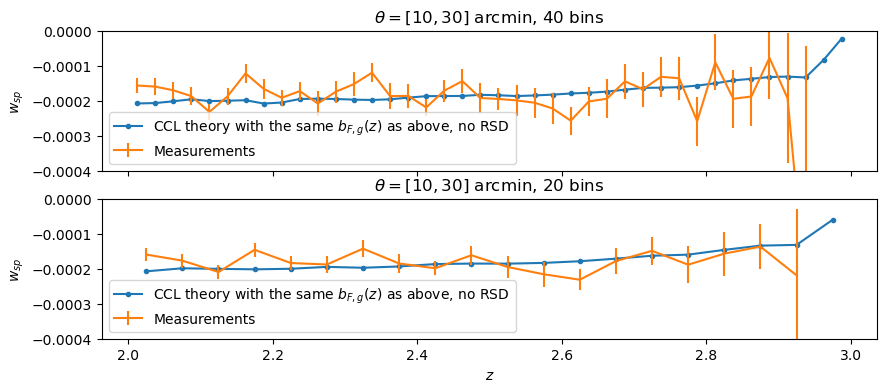

In [136]:
fig,axarr=pl.subplots(2,figsize=[10,4],sharex=True)
pl.sca(axarr[0])
pl.plot(zbins, w_sp,'.-',label="CCL theory with the same $b_{F,g}(z)$ as above, no RSD")
pl.errorbar(data_wsp[:,0], data_wsp[:,1],yerr=data_wsp[:,2],label="Measurements")
pl.ylim([-0.0004,0.0000])
pl.ylabel("$w_{sp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 40 bins")

pl.sca(axarr[1])
pl.plot(zbins20, w_sp20,'.-',label="CCL theory with the same $b_{F,g}(z)$ as above, no RSD")
pl.errorbar(data_wsp20[:,0], data_wsp20[:,1],yerr=data_wsp20[:,2],label="Measurements")
pl.ylabel("$w_{sp}$")
pl.legend()
pl.title("$\\theta=[10,30]$ arcmin, 20 bins")
pl.xlabel("$z$")
pl.ylim([-0.0004,0.0000])

In [15]:
# ell conversion
z = np.linspace(2,3,20)
d = ccl.comoving_radial_distance(cosmo_ccl, 1/(1+z))

theta_min = 10/60/180*np.pi # arcmin -> rad
theta_max = 30/60/180*np.pi # arcmin -> rad

print(d*theta_min*h)
print(d*theta_max*h)

[10.41559043 10.56517605 10.71120972 10.85382122 10.9931357  11.1292715
 11.26234084 11.39245344 11.51971136 11.64421241 11.76605143 11.88531857
 12.00209939 12.11647587 12.22852654 12.33832659 12.445948   12.5514597
 12.6549277  12.75641526]
[31.24677129 31.69552814 32.13362915 32.56146367 32.9794071  33.3878145
 33.78702253 34.17736033 34.55913408 34.93263723 35.2981543  35.65595572
 36.00629816 36.3494276  36.68557961 37.01497977 37.33784401 37.6543791
 37.96478309 38.26924577]


In [16]:
theta_min

0.0029088820866572155